In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string # special operations on strings
import spacy # language models

from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [2]:
import pandas
data=pd.read_csv("Elon_musk.csv",encoding = "latin-1")

In [3]:
data.head()

,Unnamed: 0,Text
0,1,@kunalb11 Im an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1999 non-null   int64 
 1   Text        1999 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [5]:
data.columns = ['id', 'x']

In [6]:
data.head()

,id,x
0,1,@kunalb11 Im an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [7]:
#data=data.drop(['id'], axis = 1)
#data.head()

In [8]:
data = [x.strip() for x in data.x] # remove both the leading and the trailing characters
data = [x for x in data if x] # removes empty strings, because they are considered in Python as False
data[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [9]:
##Part Of Speech Tagging
nlp = spacy.load("en_core_web_sm")

one_block = data[2]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style='ent', jupyter=True)

In [10]:
one_block

'@joerogan @Spotify Great interview!'

In [11]:
for token in doc_block[0:10]:
    print(token, token.pos_)

@joerogan PROPN
@Spotify VERB
Great ADJ
interview NOUN
! PUNCT


In [12]:
#Filtering for nouns and verbs only
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN', 'VERB')]
print(nouns_verbs[:25])

['@Spotify', 'interview']


In [13]:
#Counting tokens again
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ['word', 'count']

wf_df[0:10]

,word,count
0,spotify,1
1,interview,1


# Emotion mining

In [14]:
#Sentiment analysis
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [15]:
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [16]:
from nltk import tokenize
sentences = tokenize.sent_tokenize(" ".join(data))
sentences[5:15]

['Happy New Year of the Ox!',
 'https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all.',
 'https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed!',
 'Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O @freewalletorg Any crypto wallet that won\x92t give you your private keys should be avoided at all costs @freewalletorg Your app sucks RT @SpaceX: NASA has selected Falcon Heavy to launch the first two elem

In [17]:
sent_df = pd.DataFrame(sentences, columns=['sentence'])
sent_df

,sentence
0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...
1,Have you tried it?
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated @teslacn Congr...
4,Now on to the next for even more!!
...,...
919,"@kenyanwalstreet Not actually a payout, just a..."
920,"It may never pay out, as the stock cant b ht..."
921,Details Aug 28.
922,AI symbiosis while u wait @vistacruiser7 @flcn...


In [18]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [19]:
#Custom function :score each word in a sentence in lemmatised form, 
#but calculate the score for the whole original sentence.
nlp = spacy.load("en_core_web_sm")
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [20]:
# test that it works
calculate_sentiment(text = 'amazing')

4

In [21]:
sent_df['sentiment_value'] = sent_df['sentence'].apply(calculate_sentiment)

In [22]:
# how many words are in the sentence?
sent_df['word_count'] = sent_df['sentence'].str.split().apply(len)
sent_df['word_count'].head(10)

0     13
1      4
2      4
3     13
4      8
5      6
6     14
7     10
8      8
9    109
Name: word_count, dtype: int64

In [23]:
sent_df.sort_values(by='sentiment_value').tail(10)

,sentence,sentiment_value,word_count
183,Theres some great AI out ther https://t.co/v...,10,48
817,Might be able to https://t.co/FB7e5nOq2E @Pri...,11,72
224,"@PPathole @karpathy For a second there, I thou...",11,69
184,"Also, w https://t.co/IYdKttVsqk @cleantechnic...",12,98
42,"@thejackbeyer @NASASpaceflight Cryoproof, then...",12,84
645,Its https://t.co/IxhyT6NuiC @Teslarati Tesla...,13,65
585,The open areas https://t.co/rabjKrtQlw @Sav...,14,138
36,"@ajtourville @Erdayastronaut @SpaceX Yes, but ...",15,231
105,@Erdayastronaut @SpaceX Was also thinking that...,16,94
719,We just havent observed the https://t.co/mez...,17,72


In [24]:
# Sentiment score of the whole review
sent_df['sentiment_value'].describe()

count    924.000000
mean       1.312771
std        2.647718
min       -8.000000
25%        0.000000
50%        0.000000
75%        3.000000
max       17.000000
Name: sentiment_value, dtype: float64

In [25]:
# Sentiment score of the whole review
sent_df[sent_df['sentiment_value']<=0].head()

,sentence,sentiment_value,word_count
0,@kunalb11 Im an alien @ID_AA_Carmack Ray trac...,0,13
1,Have you tried it?,0,4
4,Now on to the next for even more!!,0,8
5,Happy New Year of the Ox!,0,6
6,https://t.co/9WFKMYu2oj Frodo was the underdog...,-2,14


In [26]:
sent_df[sent_df['sentiment_value']>=15].head()

,sentence,sentiment_value,word_count
36,"@ajtourville @Erdayastronaut @SpaceX Yes, but ...",15,231
105,@Erdayastronaut @SpaceX Was also thinking that...,16,94
719,We just havent observed the https://t.co/mez...,17,72


In [27]:
sent_df['index']=range(0,len(sent_df))

C:\Users\uniha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiment_value', ylabel='Density'>

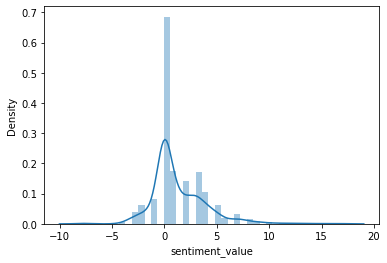

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(sent_df['sentiment_value'])

<AxesSubplot:xlabel='index', ylabel='sentiment_value'>

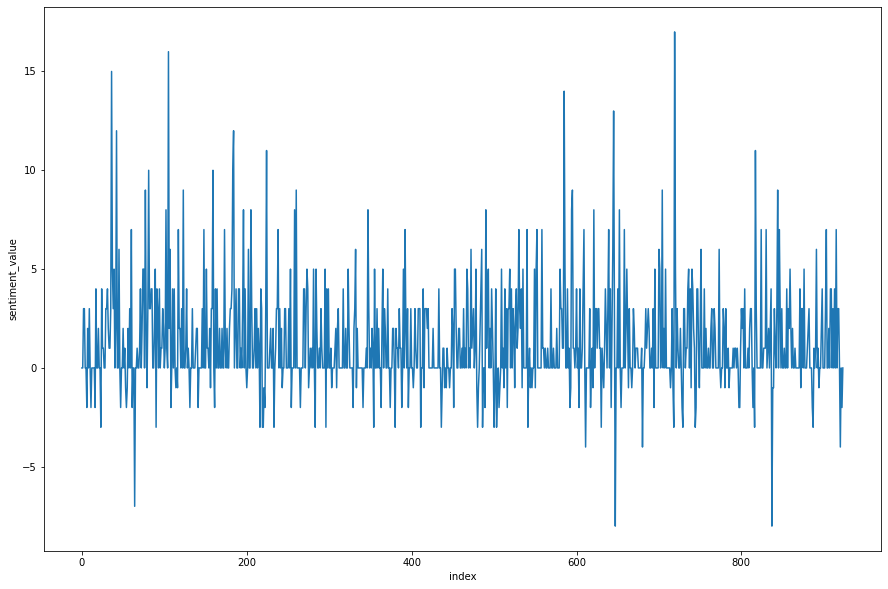

In [29]:
plt.figure(figsize=(15, 10))
sns.lineplot(y='sentiment_value',x='index',data=sent_df)

<AxesSubplot:title={'center':'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='sentiment_value'>

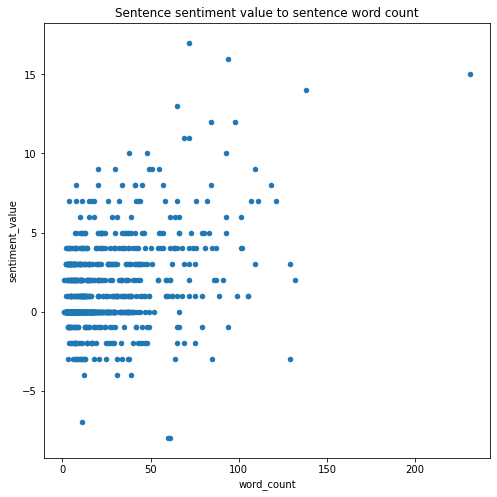

In [30]:
sent_df.plot.scatter(x='word_count', y='sentiment_value', figsize=(8,8), title='Sentence sentiment value to sentence word count')